## Set up

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "1"

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
np.set_printoptions(precision=15)

# Ensure deterministic behavior (cannot control everything though)
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from importlib import reload
import dataset_utils
reload(dataset_utils)
from dataset_utils import *

import predictor_utils
reload(predictor_utils)
from predictor_utils import *

In [2]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="GGtO5x2eJ77Wa0rLpQSt")
# project = rf.workspace("orij").project("xmm_om_images-contrast-512-v5")
# dataset = project.version(3).download("coco")

In [3]:
input_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_code_git/xmm_om_images-contrast-512-v5-3/train/'
json_file_path = '/workspace/raid/OM_DeepLearning/XMM_OM_code_git/xmm_om_images-contrast-512-v5-3/train/_annotations.coco.json'

with open(json_file_path) as f:
    data = json.load(f)

ground_truth_masks, bbox_coords = get_coords_and_masks_from_json(input_dir, data)

In [4]:
image_paths_no_augm = [input_dir+img_data['file_name'] for img_data in data['images']]
len(image_paths_no_augm)

200

## Augmentation

This algorithm performs augmentations and updates the negative masks in the case of a geometric transformations. Otherwise, it masks the result of a contrastive transformation given the mask of the initial image. Usually, the geometrical and contrastive transformations are not used simultaneously, as the notion of $<0$ pixels (negative mask) is lost.

**!! For augmentation, the bboxes are expected to be in the XYHW format, not XYXY format (used by SAM). However, the SAM AMG generated results are in the XYHW format (converted from XYXY).**


In [5]:
import os
import glob

files = glob.glob(f'{input_dir}/*augm*')

for file in files:
    os.remove(file)

In [6]:
# https://albumentations.ai/docs/examples/showcase/
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb
import albumentations as A
import random
import math

# load utils
from importlib import reload
import dataset_utils
reload(dataset_utils)
from dataset_utils import *


def enlarge_bbox(bbox, delta, image_size):
    x_min, y_min, w, h = bbox
    x_min = max(0, math.floor(x_min))
    y_min = max(0,  math.floor(y_min))
    
    w = min(image_size[1], math.ceil(w))
    h = min(image_size[0], math.ceil(h))
    return np.array([x_min, y_min, w, h])

# define some augmentations
geometrical_augmentations = A.Compose([
    A.Flip(),
    A.RandomRotate90(),
    A.RandomSizedCrop((512 - 150, 512 - 50), 512, 512),
], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)

intensity_color_augmentations = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.0, contrast_limit=0.1, p=1),
    A.Equalize(p=1)
], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)

noise_blur_augmentations = A.Compose([
    A.GaussianBlur(blur_limit=(3, 3), p=1),
    A.GaussNoise(var_limit=(10.0, 50.0), p=1),
    A.ISONoise(p=0.8),
    # A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.2, p=1) 
], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)

def align_masks_and_bboxes(augmented_set):
    '''
    Sometimes, the masks and bboxes returned by the Augmentation process do not have the same size, and (thus) they are not aligned by index. 
    This function will keep the non-empty masks and generate another bboxes given those masks.
    '''
    
    bboxes_augm = []
    masks_augm = []
    
    for mask_i in augmented_set['masks']:
        if np.any(mask_i):
            bbox = cv2.boundingRect(mask_i)
            bboxes_augm.append(bbox)
            masks_augm.append(mask_i)
    
    augmented_set['masks'] = masks_augm
    augmented_set['bboxes'] = bboxes_augm
    augmented_set['category_id'] = [1] * len(masks_augm)
    return augmented_set
    
image_paths = []
for image_path in image_paths_no_augm:
    image_paths.append(image_path)
    # print(image_path)
    # image_ = cv2.imread(image_path)
    # image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
    
    # masks = [value_i for key_i, value_i in ground_truth_masks.items() if image_path.split('/')[-1] in key_i]

    # image_size = (image_.shape[0], image_.shape[1])
    
    # # Enlarge the bounding boxes
    # bboxes_ = [enlarge_bbox(np.array([value_i[0], math.floor(value_i[1]),  math.floor(value_i[2] - value_i[0]), math.floor(value_i[3] - value_i[1])]), 5, image_size) \
    #            for key_i, value_i in bbox_coords.items() if image_path.split('/')[-1] in key_i]   

    # label_ids = [1] * len(masks) # change this
    # label_names = ['star'] # change this
    
    # img_negative_mask = (image_<0).astype(int)

    # augmented1 = augment_and_show(geometrical_augmentations, image_, masks, bboxes_, label_ids, label_names, show_title=False)
    # new_image_negative_mask = (augmented1['image']<255).astype(int)
    # print(len(augmented1['masks']), len(augmented1['bboxes']))
    
    # # augmented2 = augment_and_show(intensity_color_augmentations, augmented1['image'],  augmented1['masks'],  augmented1['bboxes'], augmented1['category_id'], label_names, show_title=False)
    
    # # mask the transform which is derived from the geometric transform
    # # augmented2['image'] = augmented2['image'] * new_image_negative_mask
    
    # augmented3 = augment_and_show(noise_blur_augmentations, image_, masks, bboxes_, label_ids, label_names, show_title=False)
    
    # # mask the transform using the image negative mask
    # augmented3['image'] = augmented3['image'] * img_negative_mask
        
    # new_filename1 = image_path.replace('.'+image_path.split('.')[-1], '_augm1.jpg')
    # new_filename2 = image_path.replace('.'+image_path.split('.')[-1], '_augm2.jpg')
    # new_filename3 = image_path.replace('.'+image_path.split('.')[-1], '_augm3.jpg')

    # augmented1 = align_masks_and_bboxes(augmented1)
    # # augmented2 = align_masks_and_bboxes(augmented2)
    # augmented3 = align_masks_and_bboxes(augmented3)

    # update_dataset_with_augms(augmented1, new_filename1, bbox_coords, ground_truth_masks, image_paths)
    # # update_dataset_with_augms(augmented2, new_filename2, bbox_coords, ground_truth_masks, image_paths)
    # update_dataset_with_augms(augmented3, new_filename3, bbox_coords, ground_truth_masks, image_paths)

In [7]:
len(image_paths)

200

In [8]:
# augmented3['image'].shape, len(augmented3['bboxes']), len(augmented3['masks']) 

In [9]:
from PIL import Image
import numpy as np

means = []
stds = []

for image_path in image_paths:
    image = Image.open(image_path)

    image_array = np.array(image) / 255.0

    mean = image_array.mean()
    std = image_array.std()

    means.append(mean)
    stds.append(std)

means = np.array(means)
stds = np.array(stds)

In [10]:
np.mean(means), np.mean(stds) 

(0.28373503075393974, 0.15569230367598036)

In [11]:
np.std(means), np.std(stds)

(0.17523797994298623, 0.04671656224084728)

## Dataset split

In [12]:
import json 
import cv2
import numpy as np
from matplotlib.path import Path
import math

def split_list(input_list, percentages):
    size = len(input_list)
    idx = 0
    output = []
    for percentage in percentages:
        chunk_size = round(percentage * size)
        chunk = input_list[idx : idx + chunk_size]
        output.append(chunk)
        idx += chunk_size
    return output

def create_dataset(image_paths, ground_truth_masks, bbox_coords):
        
    d_gt_masks, d_bboxes = {}, {}
    for img_path in image_paths:
        id = img_path.split('/')[-1]
        d_gt_masks.update({mask_id:mask_array for mask_id, mask_array in ground_truth_masks.items() if mask_id.startswith(id)})
        d_bboxes.update({bbox_id:bbox for bbox_id, bbox in bbox_coords.items() if bbox_id.startswith(id)}) 

    return d_gt_masks, d_bboxes
    
training_size, test_size, val_size = (0.7, 0.2, 0.1)
splits = split_list(image_paths, [training_size, test_size, val_size])
training_image_paths, test_image_paths, val_image_paths = splits[0], splits[1], splits[2]

train_gt_masks, train_bboxes = create_dataset(training_image_paths, ground_truth_masks, bbox_coords)
test_gt_masks, test_bboxes = create_dataset(test_image_paths, ground_truth_masks, bbox_coords)
val_gt_masks, val_bboxes = create_dataset(val_image_paths, ground_truth_masks, bbox_coords)


del ground_truth_masks, bbox_coords 

In [13]:
len(training_image_paths), len(test_image_paths), len(val_image_paths)

(140, 40, 20)

In [14]:
image_paths[0]

'/workspace/raid/OM_DeepLearning/XMM_OM_code_git/xmm_om_images-contrast-512-v5-3/train/S0810230201_L_png.rf.093b3d4ee6207a85bbc4125bcd52bb0d.jpg'

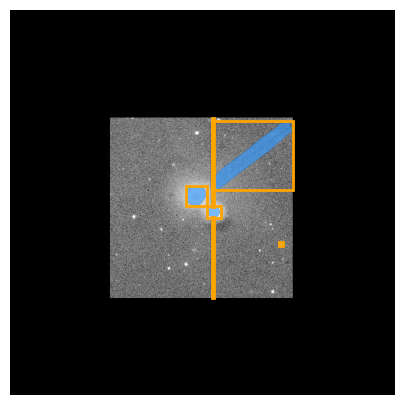

In [15]:
image_id2 = image_paths[0].split('/')[-1]
image_masks_ids = [key for key in train_gt_masks.keys() if key.startswith(image_id2)]
image_ = cv2.imread(image_paths[0])
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(image_)
for name in image_masks_ids:
        show_box(train_bboxes[name], plt.gca())
        show_mask(train_gt_masks[name], plt.gca())
plt.axis('off')
plt.show()

## 🚀 Prepare Mobile SAM Fine Tuning

In [16]:
import sys
import PIL
from PIL import Image

sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')
import ft_mobile_sam
from ft_mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/weights/mobile_sam.pt"
device = "cuda:6" if torch.cuda.is_available() else "cpu"
print("device:", device)

mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device);
mobile_sam_model.train();

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

device: cuda:6


In [17]:
use_wandb = True

if use_wandb:
    from datetime import datetime
    # !pip install wandb
    # !wandb login --relogin
    import wandb
    wandb.login()
    run = wandb.init(project="OM_AI_v1", name=f"ft_MobileSAM {datetime.now()}")

    wandb.watch(mobile_sam_model, log='all', log_graph=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: iuliaelisa15. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


## Convert the input images into a format SAM's internal functions expect.

In [18]:
# Preprocess the images
import os
from collections import defaultdict
import torch
import segment_anything
from segment_anything.utils.transforms import ResizeLongestSide
from torchvision.transforms.functional import resize

from importlib import reload
import astronomy_utils
reload(astronomy_utils)
from astronomy_utils import *

transform = ResizeLongestSide(mobile_sam_model.image_encoder.img_size)

def transform_image(image_, k):

        # invert the image
        image = 255 - image_
       
        # set a specific mean for each image
        image_T = np.transpose(image, (2, 1, 0))
        mean_ = np.mean(image_T[image_T<255])
        std_ = np.std(image_T[image_T<255]) 
        pixel_mean = torch.as_tensor([mean_, mean_, mean_], dtype=torch.float, device=device)
        pixel_std = torch.as_tensor([std_, std_, std_], dtype=torch.float, device=device)
        
        mobile_sam_model.register_buffer("pixel_mean", torch.Tensor(pixel_mean).view(-1, 1, 1), False)
        mobile_sam_model.register_buffer("pixel_std", torch.Tensor(pixel_std).view(-1, 1, 1), False)

        transformed_data = defaultdict(dict)
        transform = ResizeLongestSide(mobile_sam_model.image_encoder.img_size)
        negative_mask = np.where(image<255, True, False)
        negative_mask = torch.from_numpy(negative_mask)  
        negative_mask = negative_mask.permute(2, 0, 1)
        negative_mask = resize(negative_mask, [1024, 1024], antialias=True) 
        negative_mask = negative_mask.unsqueeze(0)
        # scales the image to 1024x1024 by longest side 
        input_image = transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, dtype=torch.float32, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
        
        # normalization and padding
        input_image = mobile_sam_model.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = tuple(transformed_image.shape[-2:])
        input_image[~negative_mask] = 0
        transformed_data['image'] = input_image
        transformed_data['input_size'] = input_size
        transformed_data['image_id'] = k
        transformed_data['original_image_size'] = original_image_size
    
        return transformed_data

In [19]:
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, image_paths, bbox_coords, gt_masks, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.bbox_coords = bbox_coords
        self.gt_masks = gt_masks
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_id = image_paths[idx].split("/")[-1]
        image = cv2.imread(image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        # plt.imshow(image)
        # plt.show()
        # plt.close()

        return self.transform(image, img_id)
        
batch_size = 8
dataset = ImageDataset(training_image_paths, train_bboxes, train_gt_masks, transform_image) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
torch.cuda.empty_cache() 

# print(torch.cuda.memory_summary(device=device, abbreviated=False))

In [21]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import torch.nn as nn

lr=3e-4
wd=5e-4
optimizer = torch.optim.AdamW(mobile_sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

ce_loss_fn = nn.CrossEntropyLoss()

scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-8) # not very helpful

def dice_loss(pred, target, negative_mask = None, area=None, smooth = 1): 
    pred = pred.contiguous()
    target = target.contiguous()    
    
    if negative_mask is not None:
        negative_mask = negative_mask.bool()
        pred = pred * negative_mask
        target = target * negative_mask 
        
    # fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    # axs[0].imshow(pred[0, 0].cpu().detach().numpy(), cmap='gray')
    # axs[0].set_title('Pred')
    # axs[1].imshow(target[0, 0].cpu().detach().numpy(), cmap='gray')
    # axs[1].set_title('Target')
    # axs[2].imshow(negative_mask[0, 0].cpu().detach().numpy(), cmap='gray')
    # axs[2].set_title('Negative Mask')
    # plt.show()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
        
    return loss.mean()

In [22]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/(1024**2)) #MB
print(torch.cuda.memory_reserved()/(1024**2))

0.0
0.0


## Print model weights before tuning

In [23]:
# weights_before = {}
# for name, param in mobile_sam_model.state_dict().items():
#     weights_before[name] = param.clone()

In [24]:
for name, param in mobile_sam_model.named_parameters():
    if "mask_decoder" in name:
    # layers_to_fine_tune = ['mask_decoder.output_hypernetworks_mlps','mask_decoder.iou_prediction_head', 'mask_decoder.output_upscaling', \
    #                        'mask_decoder.mask_tokens', 'mask_decoder.iou_token']
    # if any(s in name for s in layers_to_fine_tune): # or "image_encoder.patch_embed" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [25]:
def check_requires_grad(model, show=True):
    for name, param in model.named_parameters():
        if param.requires_grad and show:
            print("✅ Param", name, " requires grad.")
        elif param.requires_grad == False:
            print("❌ Param", name, " doesn't require grad.")

In [26]:
print(f"🚀 The model has {sum(p.numel() for p in mobile_sam_model.parameters() if p.requires_grad)} trainable parameters.\n")
check_requires_grad(mobile_sam_model)

🚀 The model has 4058340 trainable parameters.

❌ Param image_encoder.patch_embed.seq.0.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.bias  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv3.c.weigh

## The classifier

In [27]:
# import torch
# import torch.nn as nn

# class ExtendedSegmentAnythingModel(nn.Module):
#     def __init__(self, base_model, num_classes):
#         super().__init__()
#         self.base_model = base_model  
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features, 512), 
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, x):
#         masks, iou_predictions = self.base_model(x)
#         class_logits = self.classifier(masks)  # or some transformation of masks
#         return masks, iou_predictions, class_logits

# def combined_loss(pred_masks, true_masks, pred_logits, true_labels, dice_loss_fn, ce_loss_fn):
#     dice_loss = dice_loss_fn(pred_masks, true_masks)
#     ce_loss = ce_loss_fn(pred_logits, true_labels)
#     total_loss = dice_loss + ce_loss  # You can also weigh these losses differently
#     return total_loss

# num_classes = 12
# extended_model = ExtendedSegmentAnything(mobile_sam_model, num_classes).to(device)

## Run fine tuning

In [28]:
len(train_gt_masks.keys())

2182

In [29]:
# **idea** can use mixed-precision training:
# This is a technique that involves using a mix of float16 and float32 tensors 
# to make the model use less memory and run faster. 
# PyTorch provides the torch.cuda.amp module for automatic mixed-precision training.
# from torch.cuda.amp import autocast, GradScaler

In [30]:
def validate_model(): # TODO: this does something redundant
    validation_loss = []
    total_area= 0.0

    with torch.no_grad():  
        for k in val_gt_masks.keys():
            prompt_box = np.array(val_bboxes[k])
            box = predictor.transform.apply_boxes(prompt_box, original_image_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]
            
            mask_input_torch = torch.as_tensor(val_gt_masks[k], dtype=torch.float, device=device).unsqueeze(0).unsqueeze(0)

            point_coords = np.array([(val_bboxes[k][2]+val_bboxes[k][0])/2.0, (val_bboxes[k][3]+val_bboxes[k][1])/2.0])
            point_labels = np.array([1])
            point_coords = predictor.transform.apply_coords(point_coords, original_image_size)
            coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device).unsqueeze(0)
            labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=device)
            coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]

            sparse_embeddings, dense_embeddings = mobile_sam_model.prompt_encoder(
              points=(coords_torch,labels_torch),
              boxes=box_torch,
              masks=None, 
            )

            low_res_masks, iou_predictions = mobile_sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=mobile_sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            )
            
            downscaled_masks = mobile_sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
            binary_mask = torch.sigmoid(downscaled_masks - mobile_sam_model.mask_threshold)
            
            numpy_binary_mask = binary_mask.detach().cpu().numpy()
            gt_mask_resized = torch.from_numpy(np.resize(val_gt_masks[k], (1, 1, val_gt_masks[k].shape[0], val_gt_masks[k].shape[1]))).to(device)
            gt_binary_mask = torch.as_tensor(gt_mask_resized <255, dtype=torch.float32) 
            numpy_gt_binary_mask = gt_binary_mask.contiguous().detach().cpu().numpy()
            
            mask_area = np.sum(val_gt_masks[k])
            validation_loss.append(dice_loss(binary_mask, gt_binary_mask, negative_mask, mask_area) * mask_area)
            total_area += mask_area

            # print(f'val one image{k}: Allocated memory:', torch.cuda.memory_allocated()/(1024**2), 'MB. Reserved memory:', torch.cuda.memory_reserved()/(1024**2), 'MB')
            
            torch.cuda.empty_cache()
            
            # fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            
            # # Ground truth mask
            # axs[0].imshow(numpy_gt_binary_mask[0, 0], cmap='viridis')
            # axs[0].set_title('Ground Truth Mask')
            
            # # Predicted mask
            # axs[1].imshow(numpy_binary_mask[0, 0], cmap='viridis')
            # axs[1].set_title('Predicted Mask')

            # plt.show()
            # plt.close()

    validation_loss = torch.sum(validation_loss)
    validation_loss /= total_area

    return validation_loss

import predictor_utils
reload(predictor_utils)
from predictor_utils import *

def validate_model_AMG(ft_mobile_sam_model, mobile_sam_model_orig):
    validation_loss = []

    for val_img_path in val_image_paths:
        with torch.no_grad():

            print('Original MobileSAM')
            annotated_image_orig_mobile_sam, annotated_image_orig_mobile_sam_loss = amg_predict(mobile_sam_model_orig, orig_mobile_SamAutomaticMaskGenerator, \
                                                       val_gt_masks, 'ft_MobileSAM', val_img_path, mask_on_negative=False, show_plot=True)

            print('Fine-tuned MobileSAM')
            annotated_img, loss = amg_predict(mobile_sam_model, SamAutomaticMaskGenerator, val_gt_masks, 'ft_MobileSAM', \
                                              val_img_path, mask_on_negative=True, show_plot=True)
            # print('validation loss =', loss)
            validation_loss.append(loss)

    return np.mean(validation_loss)

In [31]:
def one_image_predict(image_masks):
    image_loss=[]
    mask_result = []
    total_area = 0.0
    for k in image_masks:   

                # process bboxes
                prompt_box = np.array(train_bboxes[k])
                box = predictor.transform.apply_boxes(prompt_box, original_image_size)
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                box_torch = box_torch[None, :]

                # process masks
                mask_input_torch = torch.as_tensor(train_gt_masks[k], dtype=torch.float, device=predictor.device).unsqueeze(0).unsqueeze(0)

                # process coords and labels
                x_min, y_min, x_max, y_max = train_bboxes[k]
                x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        
                point_coords = np.array([(train_bboxes[k][2]+train_bboxes[k][0])/2.0, (train_bboxes[k][3]+train_bboxes[k][1])/2.0])
                point_labels = np.array([1])
                point_coords = predictor.transform.apply_coords(point_coords, original_image_size)
                coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=predictor.device).unsqueeze(0)
                labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=predictor.device)
                coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]

                # mask_copy = train_gt_masks[k].copy()
                # mask_copy = cv2.cvtColor(mask_copy, cv2.COLOR_GRAY2BGR)
                # mask_copy = mask_copy * 255
                # print(x_min, y_min, x_max, y_max)
                # cv2.rectangle(mask_copy, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                # plt.imshow(mask_copy)
                # plt.plot((train_bboxes[k][2]+train_bboxes[k][0])/2.0, (train_bboxes[k][3]+train_bboxes[k][1])/2.0, 'ro')
                # plt.show()

                sparse_embeddings, dense_embeddings = mobile_sam_model.prompt_encoder(
                  points=(coords_torch, labels_torch),
                  boxes=box_torch, #None,
                  masks=None,
                )
                # print(box_torch.shape, mask_input_torch.shape)

                del box_torch, mask_input_torch, coords_torch, labels_torch

                # print(image_embedding.shape, mobile_sam_model.prompt_encoder.get_dense_pe().shape, sparse_embeddings.shape, dense_embeddings.shape)
                low_res_masks, iou_predictions = mobile_sam_model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=mobile_sam_model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True, # this works better for ambiguous prompts (single points)
                )
        
                # print(low_res_masks.shape)

                downscaled_masks = mobile_sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
                # binary_mask = normalize(threshold(downscaled_masks, 0.0, 0))
                binary_mask = torch.sigmoid(downscaled_masks - mobile_sam_model.mask_threshold)

                gt_mask_resized = torch.from_numpy(np.resize(train_gt_masks[k], (1, 1, train_gt_masks[k].shape[0], train_gt_masks[k].shape[1]))).to(device)
                gt_binary_mask = torch.as_tensor(gt_mask_resized<255, dtype=torch.float32) 
                numpy_gt_binary_mask = gt_binary_mask.contiguous().detach().cpu().numpy()

                # print(iou_predictions)
                mask_result.append(binary_mask[0][0].detach().cpu())

                # plt.imshow(numpy_gt_binary_mask[0][0])
                # plt.show()
        
                # compute weighted dice loss
                # print(train_gt_masks[k].shape,np.sum(train_gt_masks[k]))
                mask_area = np.sum(train_gt_masks[k])

                if mask_area > 0:
                    image_loss.append(dice_loss(binary_mask, gt_binary_mask, negative_mask, mask_area) * mask_area)
                    total_area += mask_area

                del binary_mask 
                del gt_mask_resized, numpy_gt_binary_mask 
                del low_res_masks, iou_predictions 
        
    image_loss = torch.stack(image_loss)
    image_loss = torch.sum(image_loss)
    image_loss /= total_area
    
    # plt.figure(figsize=(10, 5))
    # fig, axs = plt.subplots(1, 2)

    # axs[0].imshow(image)
    # show_masks(mask_result, axs[0])
    # axs[0].set_title('Predicted')

    # axs[1].imshow(image)
    # show_masks([train_gt_masks[k] for k in image_masks], axs[1])
    # axs[1].set_title('Ground truth')
    
    # plt.show()
    # plt.close()
    
    return image_loss

  0%|          | 0/18 [00:00<?, ?it/s]

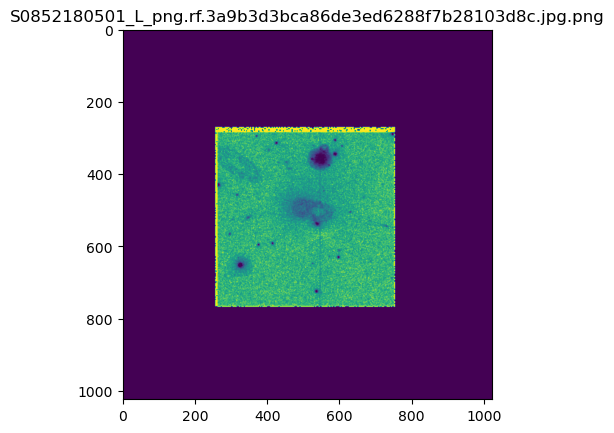

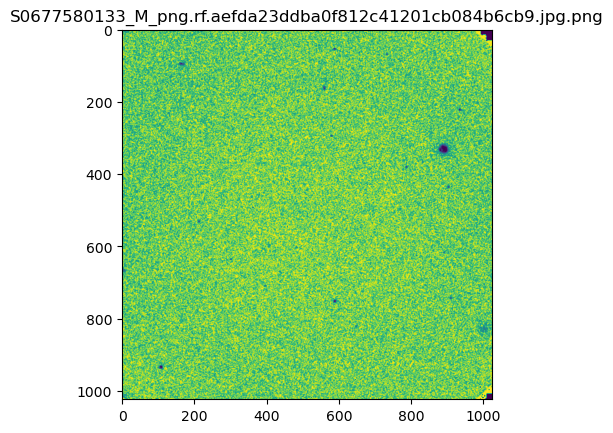

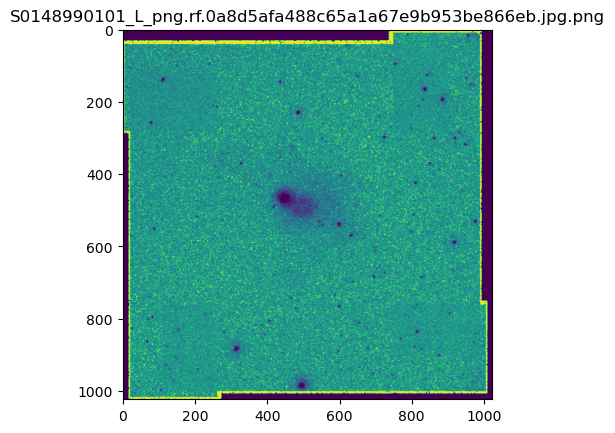

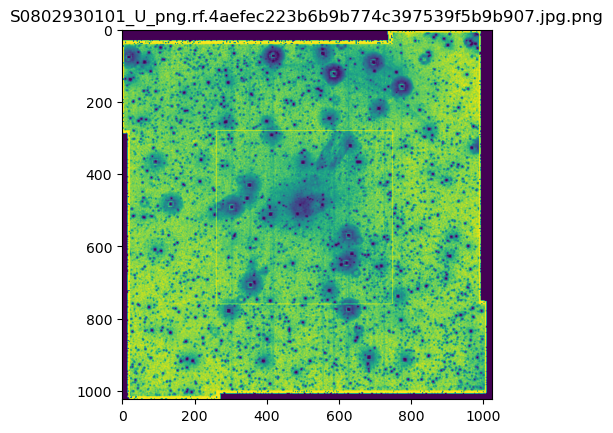

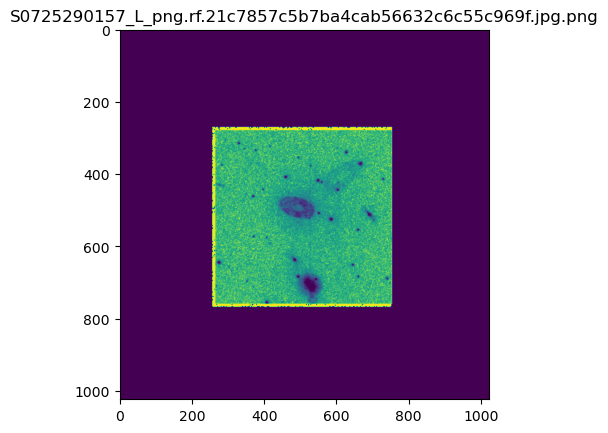

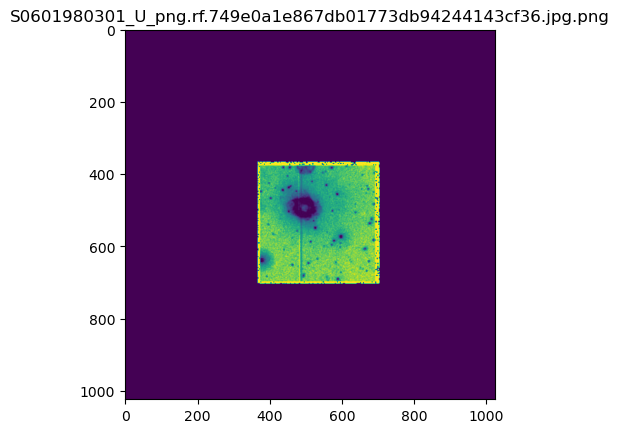

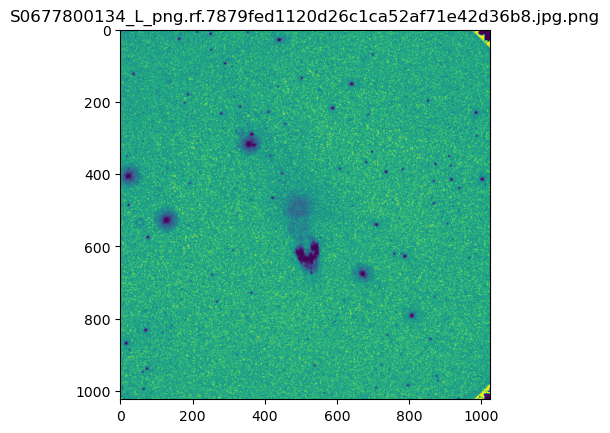

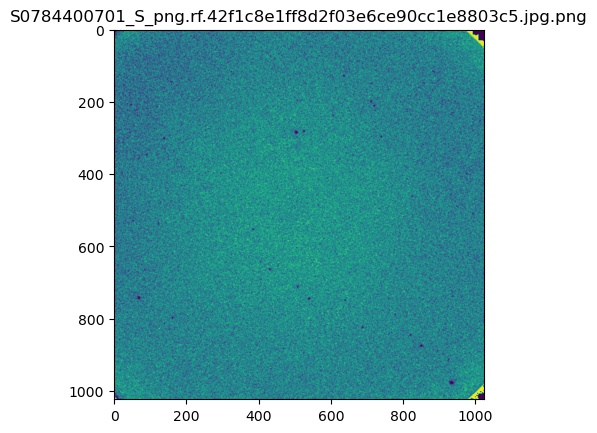

  6%|▌         | 1/18 [00:14<04:12, 14.87s/it]

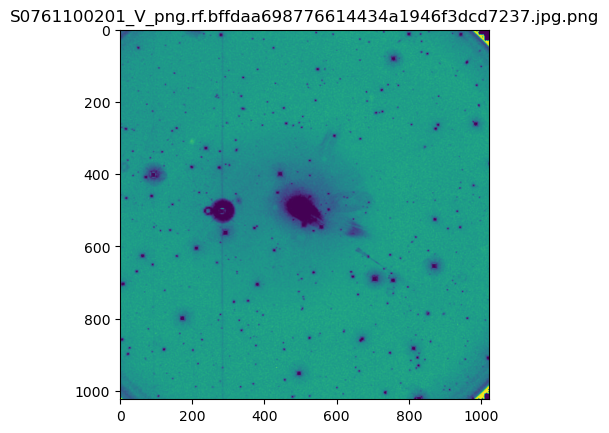

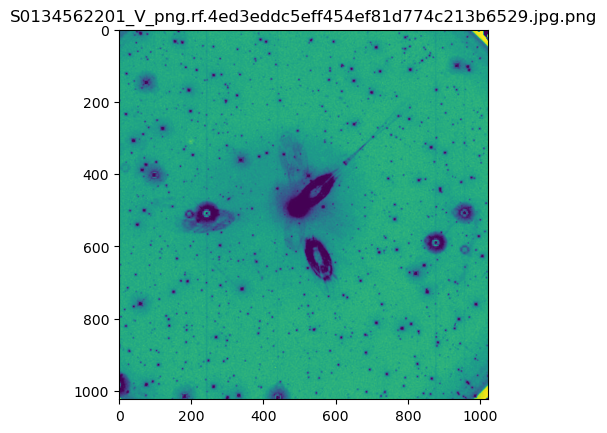

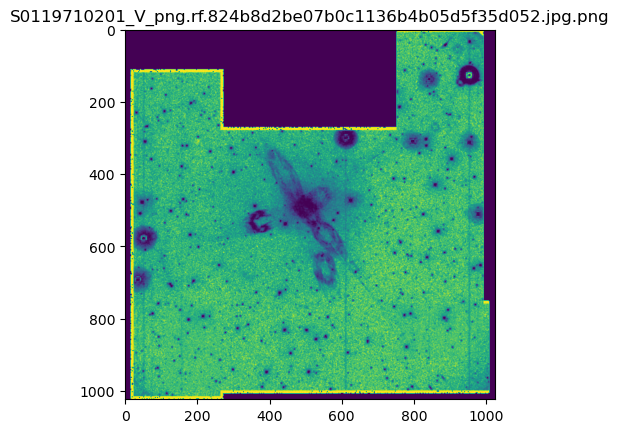

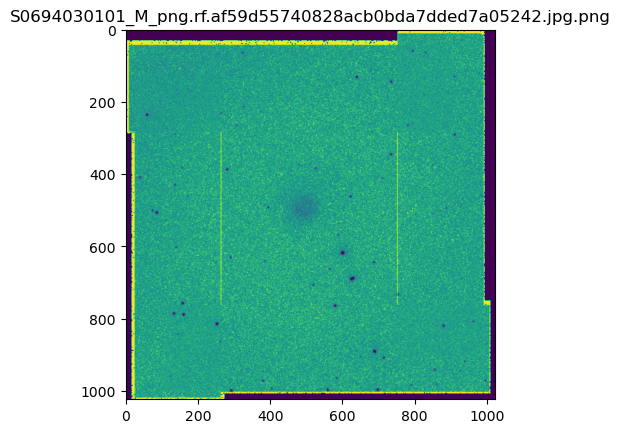

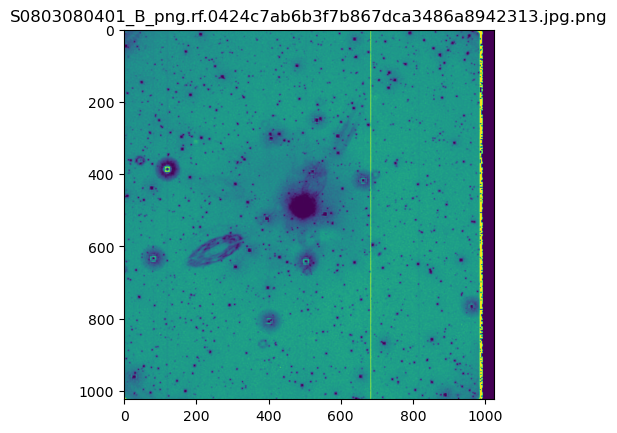

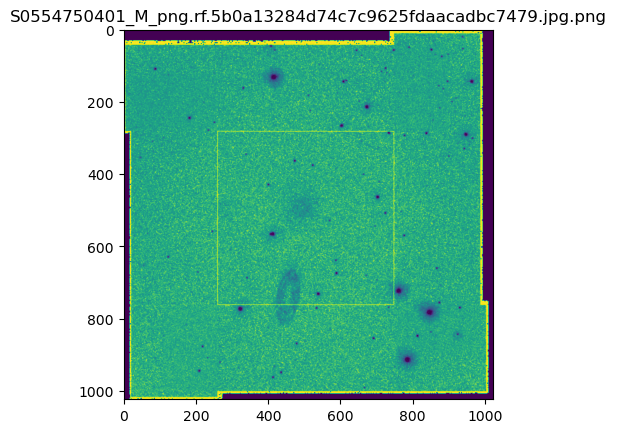

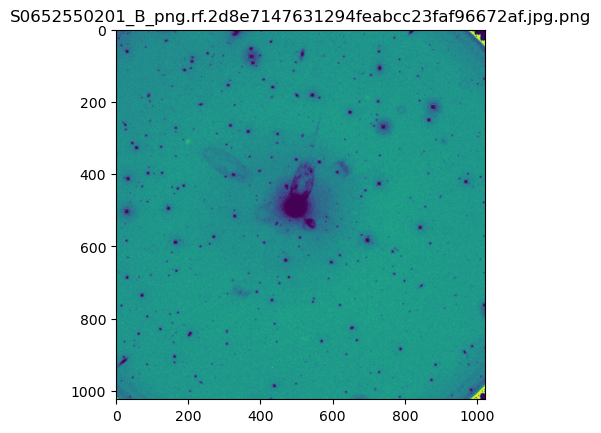

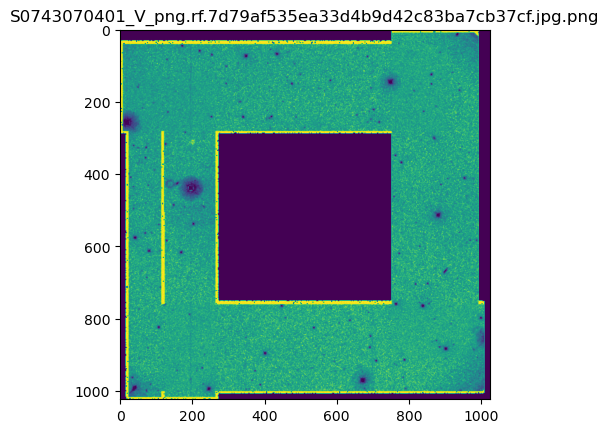

 11%|█         | 2/18 [00:43<06:04, 22.76s/it]

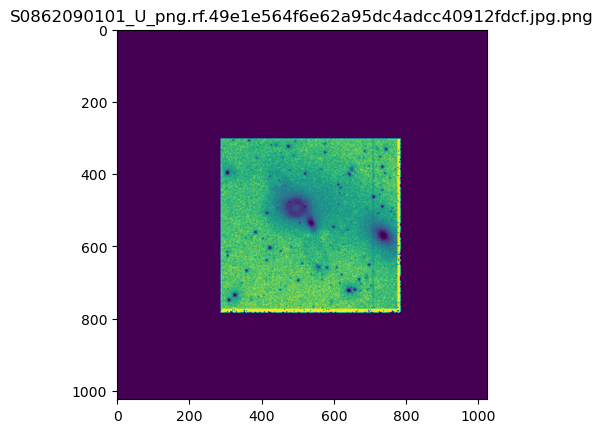

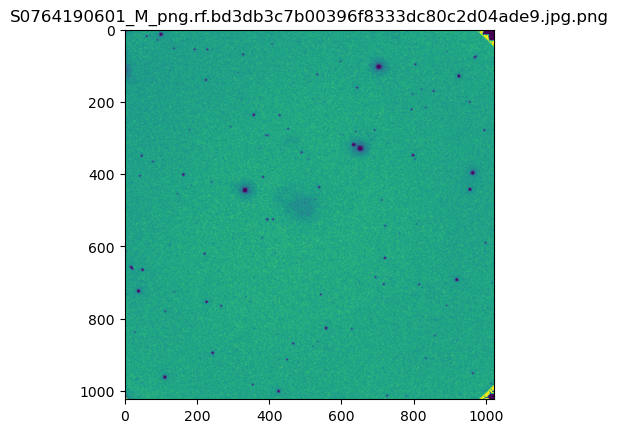

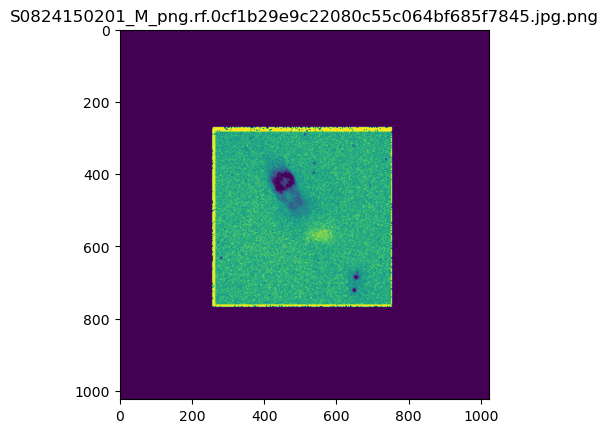

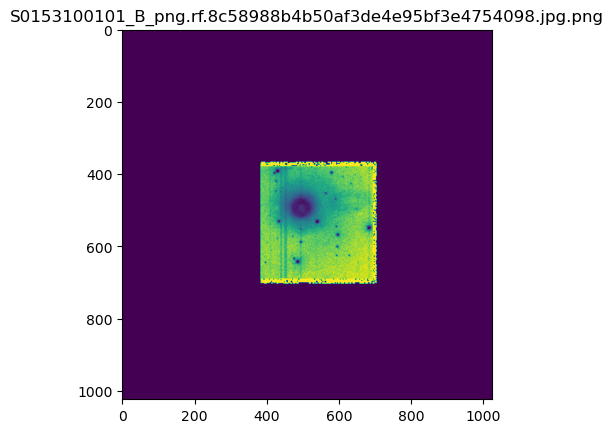

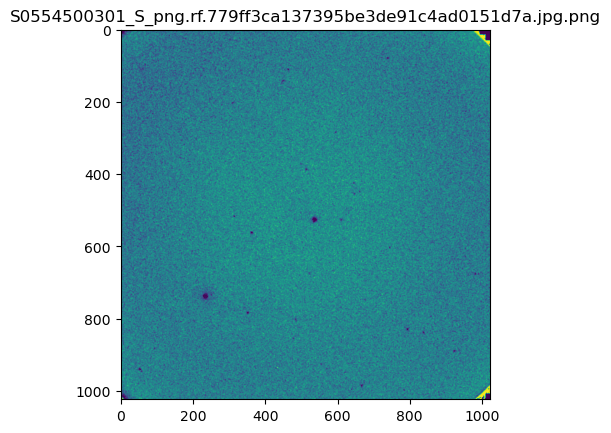

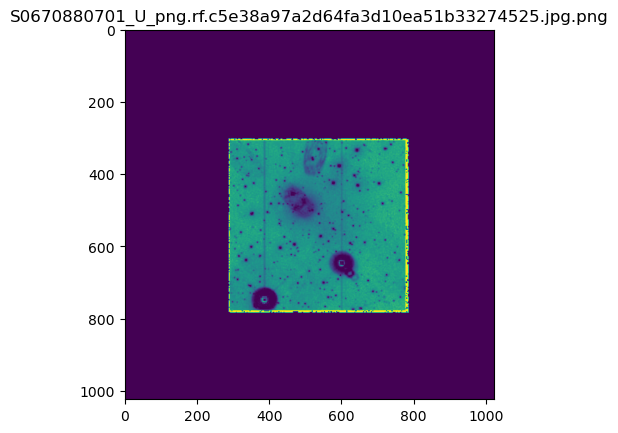

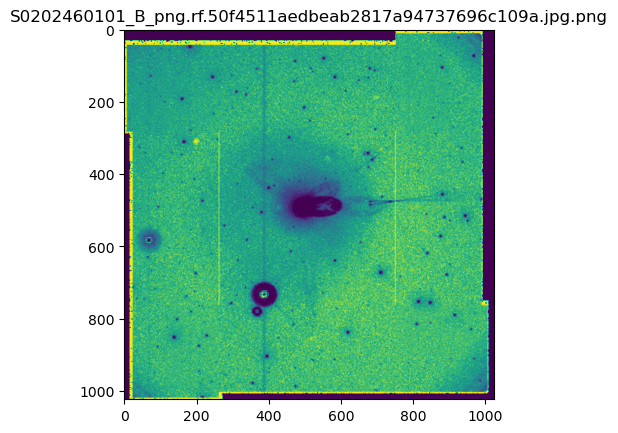

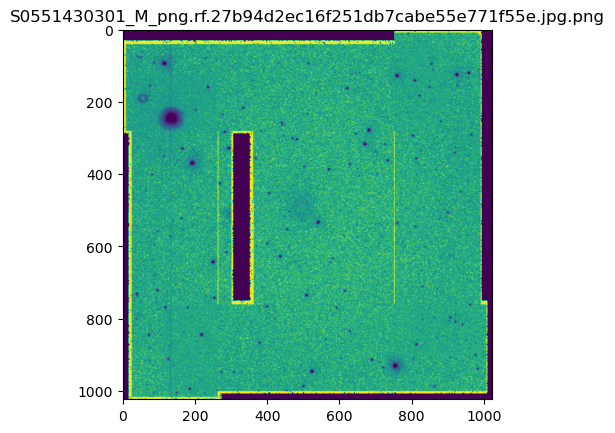

 17%|█▋        | 3/18 [00:56<04:35, 18.36s/it]

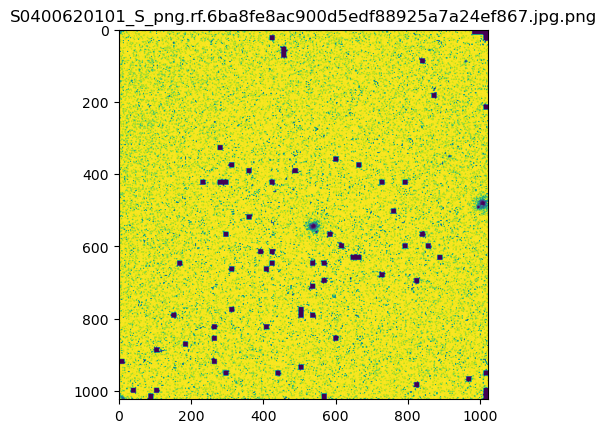

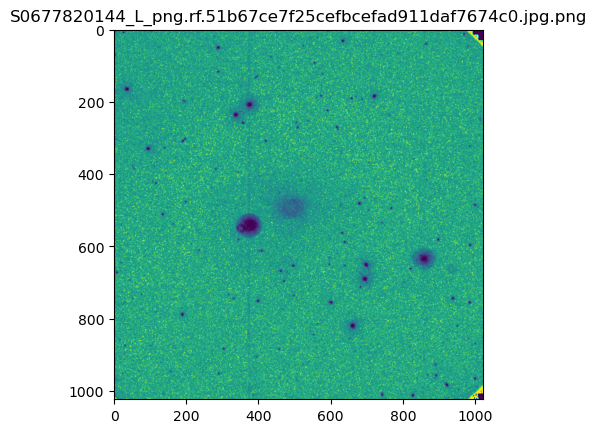

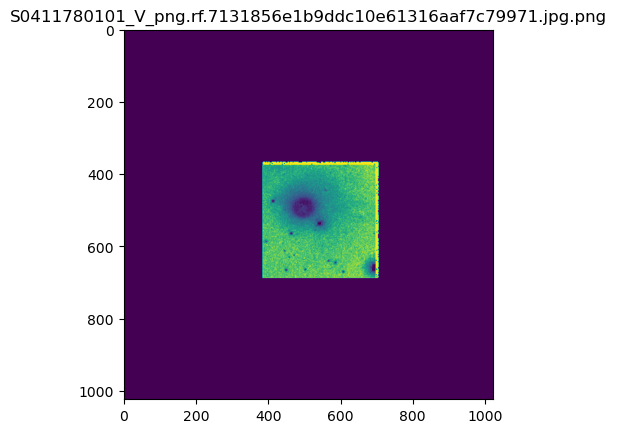

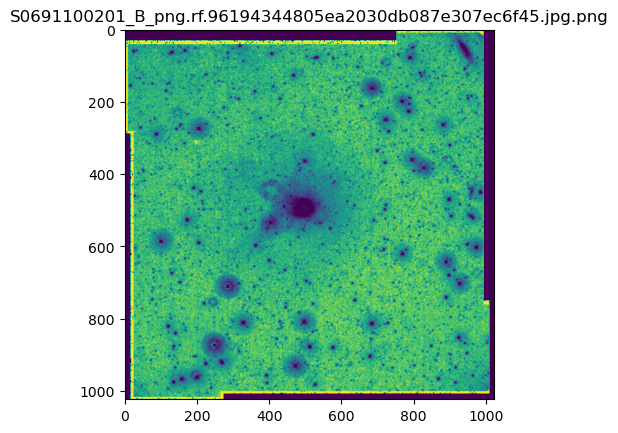

 17%|█▋        | 3/18 [00:59<04:59, 19.95s/it]


KeyboardInterrupt: 

In [33]:
from statistics import mean
from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import copy
import time

num_epochs = 1
losses = []
valid_losses = []
valid_bboxes_losses = []
predictor = SamPredictor(mobile_sam_model)

for epoch in range(num_epochs):
	
	epoch_losses = []
	for inputs in tqdm(dataloader): # take image ids
		image_loss = defaultdict(dict)
		batch_loss = 0.0
		batch_size = min(len(inputs['image']), batch_size) # at the end, there's less than batch_size imgs in a batch (sometimes)
	
		for i in range(batch_size): 
			image_loss[i]=0.0 # type: ignore
			  
			image_masks = {k for k in train_gt_masks.keys() if k.startswith(inputs['image_id'][i])}
			input_image = inputs['image'][i].to(device)
            
			image = cv2.imread(input_dir+inputs['image_id'][i])
			image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
			original_image_size = image.shape[:-1]
			input_size = (1024, 1024)
			np_image = np.transpose(input_image[0].detach().cpu().numpy(), (1, 2, 0))
			# print(np.min(np_image), np.max(np_image))
			# plt.imshow(input_image[0][0].detach().cpu(), cmap='viridis')
			# plt.title(f'{inputs["image_id"][i]}.png')
			# plt.show()

            # IMAGE ENCODER
			image_embedding = mobile_sam_model.image_encoder(input_image)
			del input_image
			   
			# negative_mask has the size of the image
			negative_mask = np.where(image<255, True, False)
			negative_mask = torch.from_numpy(negative_mask)  
			negative_mask = negative_mask.permute(2, 0, 1)
			negative_mask = negative_mask[0]
			negative_mask = negative_mask.unsqueeze(0).unsqueeze(0)
			negative_mask = negative_mask.to(device)
			del image

            # RUN PREDICTION ON IMAGE
			image_loss[i] = one_image_predict(image_masks)
			# print('after emptying cache: Allocated memory:', torch.cuda.memory_allocated()/(1024**2), 'MB. Reserved memory:', torch.cuda.memory_reserved()/(1024**2), 'MB')

			batch_loss += image_loss[i]
			del image_embedding, negative_mask 
        
		batch_loss = batch_loss * 1.0/batch_size
		epoch_losses.append(batch_loss.item())
		optimizer.zero_grad()
		batch_loss.backward() # type: ignore
		optimizer.step() 

		torch.cuda.empty_cache()
		# print('after emptying cache: Allocated memory:', torch.cuda.memory_allocated()/(1024**2), 'MB. Reserved memory:', torch.cuda.memory_reserved()/(1024**2), 'MB')

	# validation loss
	losses.append(np.mean(epoch_losses))
	# mobile_sam_model.eval();
	# # # valid_losses.append(validate_model_AMG())
	# # valid_bboxes_losses.append(validate_model())
	# mobile_sam_model.train();
	torch.cuda.empty_cache()

	if use_wandb:
		wandb.log({'epoch training loss': np.mean(epoch_losses)})
		# wandb.log({'epoch validation loss': np.mean(valid_bboxes_losses)})
	# print(f'EPOCH: {epoch}. Training loss: {np.mean(epoch_losses)}. Validation AMG loss: {np.mean(valid_losses)}. Validation bboxes loss: {np.mean(valid_bboxes_losses)} ')
	# print(f'EPOCH: {epoch}. Training loss: {np.mean(epoch_losses)}.Validation bboxes loss: {np.mean(valid_bboxes_losses)} ')
	print(f'EPOCH: {epoch}. Training loss: {np.mean(epoch_losses)}.')

	if epoch%5==0:
		torch.save(mobile_sam_model.state_dict(), f'./weights/mobile_sam_model_checkpoint{epoch}.pth')

torch.save(mobile_sam_model.state_dict(), './weights/mobile_sam_model_checkpoint.pth')

print('Training losses:', losses)
print('valid_bboxes_losses losses:', valid_bboxes_losses)
# print('Val losses:', valid_losses)

if use_wandb:
    wandb.run.summary["batch_size"] = batch_size
    wandb.run.summary["num_epochs"] = num_epochs
    wandb.run.summary["learning rate"] = lr
    wandb.run.summary["used area for DICE loss"] = 'YES'
    run.finish()

**original MobileSAM checkpoint**

In [ ]:
import sys
sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-master/')
import mobile_sam
from mobile_sam import sam_model_registry as orig_mobile_sam_registry, \
SamAutomaticMaskGenerator as orig_mobile_SamAutomaticMaskGenerator, \
SamPredictor as orig_mobile_SamPredictor

orig_mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-master/weights/mobile_sam.pt"
print("device:", device)

mobile_sam_model_orig = orig_mobile_sam_registry["vit_t" ](checkpoint=orig_mobile_sam_checkpoint)
mobile_sam_model_orig.to(device);
mobile_sam_model_orig.eval();

device: cuda:6


Original MobileSAM
❗️Did not use negative mask in AMG.❗️


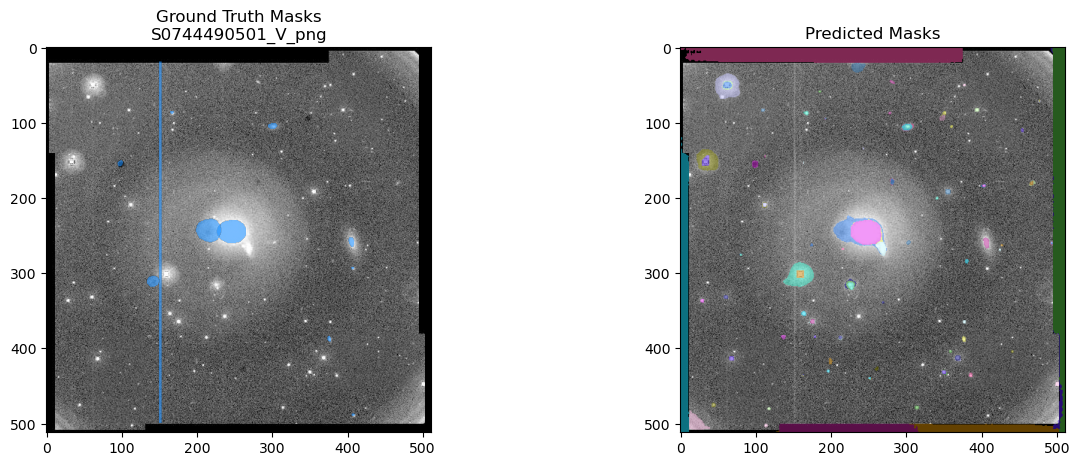

Fine-tuned MobileSAM


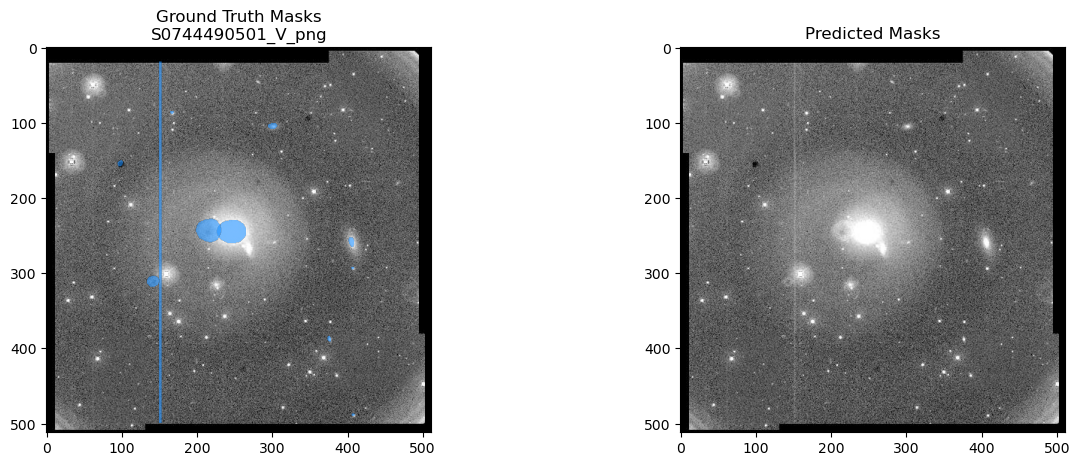

Original MobileSAM
❗️Did not use negative mask in AMG.❗️


KeyboardInterrupt: 

In [ ]:
validate_model_AMG(mobile_sam_model, mobile_sam_model_orig)

In [ ]:
print('valid_losses', valid_losses)
print('valid_bboxes_losses', valid_bboxes_losses)

In [ ]:
# check the GPU memory after training
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/(1024**2)) #MB
print(torch.cuda.memory_reserved()/(1024**2))

In [ ]:
plt.plot(list(range(len(losses))), losses, label='Training Loss')
plt.plot(list(range(len(valid_bboxes_losses))), valid_bboxes_losses, label='Validation Loss')
plt.title('Mean epoch loss \n mask with sigmoid')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./plots/loss_mask_valid_points_prompt.png')
plt.show()

In [ ]:
# plt.plot(list(range(len(losses))), losses)
# plt.title('Mean epoch loss \n mask with sigmoid')
# plt.xlabel('Epoch Number')
# plt.ylabel('Loss')
# plt.savefig('loss_mask_sigmoid_training.png')
# plt.show()
# plt.close()